In [1]:
!pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.5/828.5 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 60.9 MB/s eta 0:00:00


In [2]:

from typing import Tuple, List
import torch
from torch.utils.data import Dataset
import torchaudio
from glob import glob
from transformers import ASTModel, AutoFeatureExtractor

class AudioDatasetWave(Dataset):
    """
    Dataset for loading raw waveform audio files with labels.

    Attributes:
        sample_rate (int): Target sample rate for resampling audio.
        data (List[str]): List of audio file paths.
        labels (torch.Tensor): Tensor containing labels (0 or 1).
    """
    def __init__(self, root_dir: str, sample_rate: int = 16000) -> None:
        """
        Initialize the dataset by scanning class directories for WAV files.

        Args:
            root_dir (str): Root directory containing class_0/ and class_1/ folders.
            sample_rate (int, optional): Target sample rate for audio. Defaults to 16000.
        """
        self.sample_rate: int = sample_rate
        self.data: List[str] = []
        self.labels: List[int] = []

        for i, class_name in enumerate(['class_0', 'class_1']):
            files = glob(f"{root_dir}/{class_name}/*.wav")
            self.data.extend(files)
            self.labels.extend([i]*len(files))

        self.labels = torch.tensor(self.labels)

    def __len__(self) -> int:
        """Return the total number of audio samples."""
        return len(self.data)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        """
        Load a waveform and its label.

        Args:
            idx (int): Index of the sample.

        Returns:
            Tuple[torch.Tensor, int]: waveform and label
        """
        waveform, sr = torchaudio.load(self.data[idx])
        waveform = waveform.mean(dim=0)  # Convert to mono
        if sr != self.sample_rate:
            waveform = torchaudio.functional.resample(waveform, sr, self.sample_rate)
        return waveform, self.labels[idx].item()


class AudioDatasetAST(Dataset):
    """
    Dataset for extracting AST CLS embeddings from waveforms.

    Attributes:
        wave_dataset (AudioDatasetWave): Raw waveform dataset.
        ast_model (ASTModel): Pretrained AST model.
        feature_extractor (AutoFeatureExtractor): Feature extractor for AST.
        device (str): Device to run AST model on ('cpu' or 'cuda').
    """
    def __init__(self, wave_dataset: AudioDatasetWave, ast_model: ASTModel,
                 feature_extractor: AutoFeatureExtractor, device: str = "cpu") -> None:
        """
        Initialize AST dataset with frozen AST model.

        Args:
            wave_dataset (AudioDatasetWave): Waveform dataset.
            ast_model (ASTModel): Pretrained AST model.
            feature_extractor (AutoFeatureExtractor): AST feature extractor.
            device (str, optional): Device for computation. Defaults to "cpu".
        """
        self.wave_dataset: AudioDatasetWave = wave_dataset
        self.ast_model: ASTModel = ast_model.to(device)
        self.feature_extractor: AutoFeatureExtractor = feature_extractor
        self.device: str = device

        self.ast_model.eval()
        for param in self.ast_model.parameters():
            param.requires_grad = False

    def __len__(self) -> int:
        """Return the number of samples in the dataset."""
        return len(self.wave_dataset)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        """
        Extract CLS embedding for a waveform and return with label.

        Args:
            idx (int): Index of the sample.

        Returns:
            Tuple[torch.Tensor, int]: CLS embedding and label
        """
        waveform, label = self.wave_dataset[idx]
        inputs = self.feature_extractor(
            waveform.numpy(),
            sampling_rate=16000,
            return_tensors="pt",
            do_normalize=True
        )
        input_values: torch.Tensor = inputs["input_values"].to(self.device)
        with torch.no_grad():
            outputs = self.ast_model(input_values=input_values)
            cls_embedding: torch.Tensor = outputs.last_hidden_state[:, 0, :]
        return cls_embedding.squeeze(0), label


In [3]:
"""
This module defines the MLP classifier and PyTorch Lightning wrapper for audio embeddings.
"""

import torch
import torch.nn as nn
import lightning.pytorch as pl

class MLPClassifier(nn.Module):
    """
    Simple multi-layer perceptron for classification.

    Attributes:
        mlp (nn.Sequential): Feed-forward layers.
    """
    def __init__(self, input_dim: int, hidden_dim: int = 256) -> None:
        """
        Initialize the MLP.

        Args:
            input_dim (int): Dimensionality of input embeddings.
            hidden_dim (int, optional): Hidden layer size. Defaults to 256.
        """
        super().__init__()
        self.mlp: nn.Sequential = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the MLP.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_dim)

        Returns:
            torch.Tensor: Output logits of shape (batch_size,)
        """
        return self.mlp(x).squeeze()


class LitMLP(pl.LightningModule):
    """
    PyTorch Lightning module for training MLPClassifier.

    Attributes:
        model (MLPClassifier): The MLP classifier.
        criterion (nn.BCEWithLogitsLoss): Binary cross-entropy loss.
        lr (float): Learning rate.
    """
    def __init__(self, input_dim: int, lr: float = 1e-3) -> None:
        """
        Initialize the Lightning module.

        Args:
            input_dim (int): Dimensionality of input embeddings.
            lr (float, optional): Learning rate. Defaults to 1e-3.
        """
        super().__init__()
        self.model: MLPClassifier = MLPClassifier(input_dim)
        self.criterion: nn.BCEWithLogitsLoss = nn.BCEWithLogitsLoss()
        self.lr: float = lr

    def training_step(self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
        """
        Perform a training step.

        Args:
            batch (tuple): (inputs, labels)
            batch_idx (int): Batch index (unused)

        Returns:
            torch.Tensor: Computed loss
        """
        x, y = batch
        x, y = x.to(self.device), y.to(self.device).float()
        logits: torch.Tensor = self.model(x)
        loss: torch.Tensor = self.criterion(logits, y)
        preds: torch.Tensor = (torch.sigmoid(logits) > 0.5).long()
        acc: torch.Tensor = (preds == y.long()).float().mean()
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        return loss

    def validation_step(self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> None:
        """
        Perform a validation step.

        Args:
            batch (tuple): (inputs, labels)
            batch_idx (int): Batch index (unused)
        """
        x, y = batch
        x, y = x.to(self.device), y.to(self.device).float()
        logits: torch.Tensor = self.model(x)
        loss: torch.Tensor = self.criterion(logits, y)
        preds: torch.Tensor = (torch.sigmoid(logits) > 0.5).long()
        acc: torch.Tensor = (preds == y.long()).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def configure_optimizers(self) -> torch.optim.Optimizer:
        """Return optimizer for training."""
        return torch.optim.Adam(self.parameters(), lr=self.lr)


In [4]:
"""

This module provides function to evaluate a trained audio classification model based on pretrained AST and MLP classifier.

"""

from typing import Tuple
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader


def evaluate_model(model: LitMLP, dataloader: DataLoader, device: str = 'cpu') -> None:
    """
    Evaluate a trained PyTorch Lightning model on a dataset.

    Args:
        model (LitMLP): Trained PyTorch Lightning model.
        dataloader (DataLoader): DataLoader for evaluation data.
        device (str, optional): Device to perform computations ('cpu' or 'cuda'). Defaults to 'cpu'.

    Returns:
        None
    """
    model.eval()
    model = model.to(device)
    all_logits, all_labels = [], []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            logits = model.model(x)
            all_logits.append(logits.cpu())
            all_labels.append(y)

    all_logits = torch.cat(all_logits).numpy()
    all_labels = torch.cat(all_labels).numpy()
    all_probs = 1 / (1 + np.exp(-all_logits))
    all_preds = (all_probs > 0.5).astype(int)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    print(f"Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1-score: {f1:.3f}")

    # ROC curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='blue', label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

    return None


In [8]:
from google.colab import drive
drive.mount('/content/drive')
data_dir="/content/drive/MyDrive/forest_fire_dataset"
batch_size: int = 8
max_epochs: int = 5
device: str = None
checkpoint_path: str = "checkpoints/lit_mlp_checkpoint.ckpt"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
device = device or ("cuda" if torch.cuda.is_available() else "cpu")

from pathlib import Path
import torch
from torch.utils.data import DataLoader, random_split
from transformers import ASTModel, AutoFeatureExtractor
import lightning.pytorch as pl



full_dataset = AudioDatasetWave(data_dir)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_wave, val_wave = random_split(full_dataset, [train_size, val_size])

# Load AST model and feature extractor
feature_extractor = AutoFeatureExtractor.from_pretrained(
    "MIT/ast-finetuned-audioset-10-10-0.4593"
)
ast_model = ASTModel.from_pretrained(
    "MIT/ast-finetuned-audioset-10-10-0.4593"
)

# Create AST embedding datasets
train_dataset = AudioDatasetAST(train_wave, ast_model, feature_extractor, device=device)
val_dataset = AudioDatasetAST(val_wave, ast_model, feature_extractor, device=device)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Initialize Lightning model
lit_model = LitMLP(input_dim=ast_model.config.hidden_size).to(device)

# Train
trainer = pl.Trainer(max_epochs=max_epochs, accelerator="auto", devices=1, log_every_n_steps=1)
trainer.fit(lit_model, train_loader, val_loader)



Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


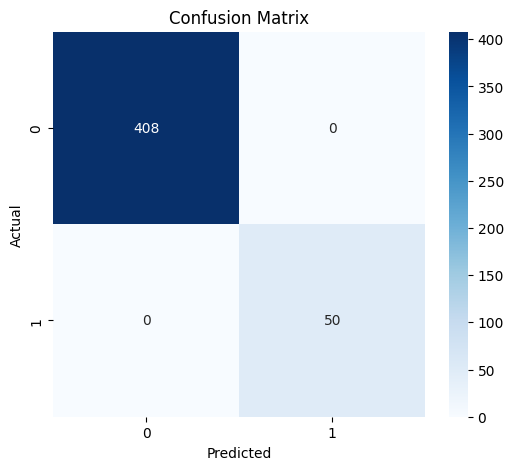

Accuracy: 1.000, Precision: 1.000, Recall: 1.000, F1-score: 1.000


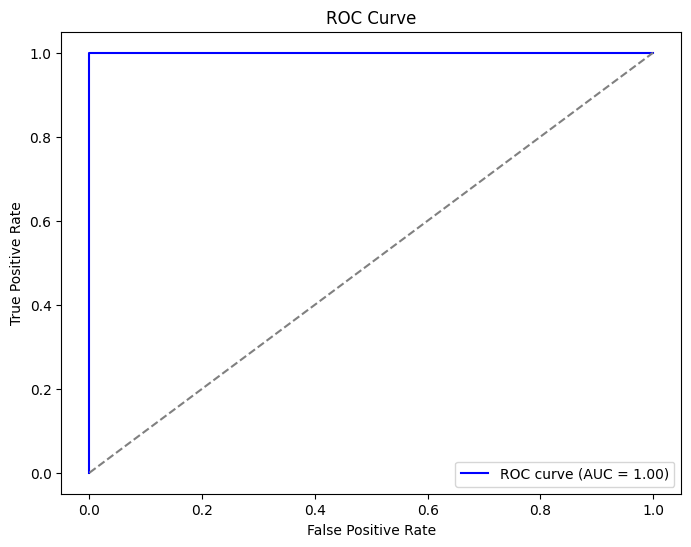

Checkpoint saved to checkpoints/lit_mlp_checkpoint.ckpt


In [11]:
# Evaluate
evaluate_model(lit_model, val_loader, device=device)

# Save checkpoint
Path(checkpoint_path).parent.mkdir(parents=True, exist_ok=True)
trainer.save_checkpoint(checkpoint_path)
print(f"Checkpoint saved to {checkpoint_path}")

In [12]:
len(train_wave), len(val_wave)

(1831, 458)

In [13]:

labels = torch.tensor([full_dataset.labels[i] for i in train_wave.indices])

num_ones = (labels == 1).sum().item()
num_zeros = (labels == 0).sum().item()

print(f"for train set : \nLabel=1: {num_ones} ({num_ones/len(labels):.2%})")
print(f"Label=0: {num_zeros} ({num_zeros/len(labels):.2%})")

labels = torch.tensor([full_dataset.labels[i] for i in val_wave.indices])

num_ones = (labels == 1).sum().item()
num_zeros = (labels == 0).sum().item()

print(f"for val set : \nLabel=1: {num_ones} ({num_ones/len(labels):.2%})")
print(f"Label=0: {num_zeros} ({num_zeros/len(labels):.2%})")

for train set : 
Label=1: 239 (13.05%)
Label=0: 1592 (86.95%)
for val set : 
Label=1: 50 (10.92%)
Label=0: 408 (89.08%)
